In [1]:
import numpy as np
import pandas as pd
from numpy.random import normal as norm
from matplotlib import pyplot as plt
import random
import pickle
from fairsearchdeltr import Deltr
%matplotlib inline
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('processed_data.csv')
df

gender  n_usa  citations
0           0      1  12.237111
1           0      0  11.188455
2           0      1  11.364402
3           0      1  11.534667
4           0      0  11.946285
...       ...    ...        ...
80205       0      1   6.424869
80206       0      1   5.257495
80207       0      1   5.598422
80208       0      1   5.036953
80209       0      1   8.488588

[80210 rows x 3 columns]

In [3]:
def sample_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

def sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = sample_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"

            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)

        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)

    return stratified_df.sample(frac=1).reset_index(drop=True)

In [4]:
def df_to_operating_tuple(df):
    return [(item['citations'], (int(item['gender']), int(item['n_usa']))) for index, item in df.iterrows()]

In [5]:
def add_additional_cols(df):
    df['q_id'] = 1
    df['doc_id'] = pd.Series(range(df.shape[0]))
    df['judgement'] = (df['citations'] - df['citations'].min()) / (df['citations'].max() - df['citations'].min())
    df = df[['q_id', 'doc_id', 'gender', 'n_usa', 'citations', 'judgement']]
    return df

In [6]:
# setup the DELTR object
protected_feature = "gender"  # column name of the protected attribute (index after query and document id)
gamma = 500  # value of the gamma parameter
number_of_iterations = 5  # number of iterations the training should run
standardize = True  # let's apply standardization to the features

# create the Deltr object
dtr = Deltr(protected_feature, gamma, number_of_iterations, standardize=standardize)

In [7]:
epoch = 5

for i in tqdm(range(epoch)):
    df_train = sample(df, ['gender', 'n_usa'])
    df_train = add_additional_cols(df_train)
    df_without_nusa = df_train[['q_id', 'doc_id', 'gender', 'citations', 'judgement']]
    dtr.train(df_without_nusa)

  0%|          | 0/5 [00:00<?, ?it/s]

.
.
.
.
.


In [8]:
with open('dltr_citations_obj', 'wb') as obj_file:
    pickle.dump(dtr, obj_file)

In [9]:
dltr_saved: Deltr = None

with open('dltr_citations_obj', 'rb') as obj_file:
    dltr_saved = pickle.load(obj_file)

print(dltr_saved.log)

[<TrainStep [1643401787183,[0.00342959 0.0143573 ],[[ 0.00023621 -0.00301002]
 [ 0.00023621 -0.00301002]
 [ 0.00023621 -0.00301002]
 ...
 [ 0.00023621 -0.00301002]
 [ 0.00023621 -0.00301002]
 [ 0.00023621 -0.00301002]],2329.9501519883547,0.0]>, <TrainStep [1643401793190,[0.00290268 0.02130285],[[ 0.00022614 -0.00298092]
 [ 0.00022614 -0.00298092]
 [ 0.00022614 -0.00298092]
 ...
 [ 0.00022614 -0.00298092]
 [ 0.00022614 -0.00298092]
 [ 0.00022614 -0.00298092]],2329.900906247569,0.0]>, <TrainStep [1643401799151,[0.00239836 0.02818124],[[ 0.00021645 -0.0029521 ]
 [ 0.00021645 -0.0029521 ]
 [ 0.00021645 -0.0029521 ]
 ...
 [ 0.00021645 -0.0029521 ]
 [ 0.00021645 -0.0029521 ]
 [ 0.00021645 -0.0029521 ]],2329.8526271238575,0.0]>, <TrainStep [1643401804889,[0.00191577 0.03499308],[[ 0.00020712 -0.00292354]
 [ 0.00020712 -0.00292354]
 [ 0.00020712 -0.00292354]
 ...
 [ 0.00020712 -0.00292354]
 [ 0.00020712 -0.00292354]
 [ 0.00020712 -0.00292354]],2329.8052949197886,0.0]>, <TrainStep [164340181107

In [10]:
rnk_w_g = dltr_saved.rank(df_without_nusa[['q_id', 'doc_id', 'gender', 'citations']])
rnk_w_g.head(5)

doc_id  gender  judgement
83        83       0   0.069805
1140    1140       0   0.068402
1573    1573       0   0.068362
1177    1177       1   0.068124
138      138       0   0.067467

In [11]:
# return individuals with top percieved qualities
def getTop(df, top = 0.1):
    data = df.copy().sort_values(['citations'], ascending=[0])
    items = data[:int(data.shape[0] * top)]
    return df_to_operating_tuple(items)

In [12]:
def getTopDebiased(data, top=0.1):
    df = data.copy()
    items = dltr_saved.rank(df[['q_id', 'doc_id', 'gender', 'citations']])[:int(df.shape[0] * top)]
    return [(df.loc[index]['citations'], (int(df.loc[index]['gender']), int(df.loc[index]['n_usa']))) for index, _ in items.iterrows()]

In [13]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(data, N, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}

    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in tqdm(range(0, Nsim), desc='Simulation'):

            # properties, perceived qualities and real qualities
            df_gen = sample(data, ['gender', 'n_usa'], N)
            df_gen = add_additional_cols(df_gen)

            for group in groups:

                # compute expected chances to be in top
                exp = df_gen[(df_gen['gender'] == group)].shape[0] / df_gen.shape[0]

                for approach in ['original', 'debiased']:

                    if approach == 'original':
                        top = getTop(df_gen, k)
                    else:
                        top = getTopDebiased(df_gen, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)

                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

# get_aggregated(df, f, Nsim, k_range)

In [14]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [17]:
# for quick results
Nsim = 5
print('Number of Simulations : ', Nsim)

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]
print('Ranking Indexes : ', k_range)

Number of Simulations :  5
Ranking Indexes :  [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]


Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

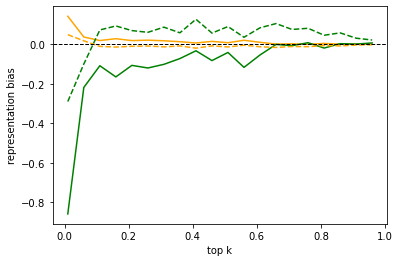

In [22]:
results_agg = get_aggregated(df, 1000, Nsim, k_range)
plot_aggregated(results_agg)

In [23]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(data, N, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            # properties, perceived qualities and real qualities
            df_gen = sample(data, ['gender', 'n_usa'], N)
            df_gen = add_additional_cols(df_gen)

            for g in groups:
                # compute expected chances to be in top
                exp = df_gen[(df_gen['gender'] == g[0]) & (df_gen['n_usa'] == g[1])].shape[0] / df_gen.shape[0]
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(df_gen, k)
                    else:
                       top = getTopDebiased(df_gen, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

In [24]:
def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

Simulations for Top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

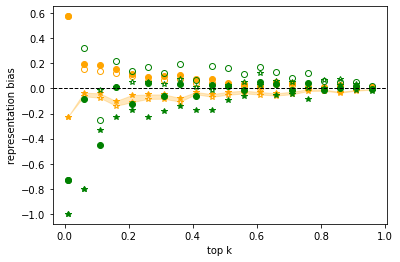

In [25]:
results_dis_agg = get_disaggregated(df, 1000, Nsim, k_range)
plot_disaggregated(results_dis_agg)

In [26]:
np.save('results_deltr_citations.npy', {'agg': results_agg, 'diss_agg': results_dis_agg})

In [27]:
read_dictionary = np.load('results_deltr_citations.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.14067441860465119,
    0.03591860465116276,
    0.017930232558139508,
    0.027188953488372098,
    0.017627906976744167,
    0.019802325581395375,
    0.016769692423105796,
    0.011992894056847548,
    0.005542257515598404,
    0.013651668351870597,
    0.006933880528955763,
    0.019290697674418582,
    0.009014105985512767,
    0.00029457364341083786,
    0.001327874222076609,
    -0.0011441248470012285,
    0.0032991673844387378,
    -0.00035343428880474647,
    -2.325581395352114e-05,
    -0.0009399224806201587],
   1: [-0.8580141843971631,
    -0.21907801418439724,
    -0.10936170212765961,
    -0.16583333333333336,
    -0.10751773049645397,
    -0.12078014184397161,
    -0.10228323038206363,
    -0.07314814814814817,
    -0.033803840166061236,
    -0.08326549491211839,
    -0.04229175358086502,
    -0.11765957446808514,
    -0.0549796535286595,
    -0.0017966903073286717,
    -0.008099090999900083,
    0.006978350130645752,
    -0.020122581210051678,